# YOLOF using MMdetection on Stanford Cars Dataset

In [1]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 704.4MB 25kB/s 
     |████████████████████████████████| 6.7MB 19kB/s 
ERROR: torchtext 0.10.0 has requirement torch==1.9.0, but you'll have torch 1.5.1+cu101 which is incompatible.
  Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
  Found existing installation: torchvision 0.10.0+cu102
    Uninstalling torchvision-0.10.0+cu102:
      Successfully uninstalled torchvision-0.10.0+cu102


In [3]:
#***************************************************
#  Hangs for 10 min while building wheel but it's ok
#***************************************************
# install mmcv-full thus we could use CUDA operators
!pip install mmcv-full

# Install mmdetection
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

!pip install -e .

# install Pillow 7.0.0 back in order to avoid bug in colab
!pip install Pillow==7.0.0


     |████████████████████████████████| 317kB 25.7MB/s 
     |████████████████████████████████| 194kB 45.1MB/s 
  Created wheel for mmcv-full: filename=mmcv_full-1.3.9-cp37-cp37m-linux_x86_64.whl size=25626301 sha256=d823f14019231cf08ce6c479d3940531c633de8de91bbc0ee602db59dce85201
  Stored in directory: /root/.cache/pip/wheels/e0/2b/d5/410850bd0f29e241507daf354083142a0c25d66667f22e707a
Successfully built mmcv-full
Cloning into 'mmdetection'...
remote: Enumerating objects: 19386, done.
remote: Counting objects: 100% (317/317), done.
remote: Compressing objects: 100% (214/214), done.
remote: Total 19386 (delta 131), reused 225 (delta 102), pack-reused 19069
Receiving objects: 100% (19386/19386), 23.66 MiB | 30.98 MiB/s, done.
Resolving deltas: 100% (13538/13538), done.
/content/mmdetection
Obtaining file:///content/mmdetection
  Cloning https://github.com/cocodataset/panopticapi.git to /tmp/pip-install-mdiuelbs/panopticapi
  Running command git clone -q https://github.com/cocodataset/pan

In [4]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.5.1+cu101 True
2.14.0
11.0
GCC 7.5


In [5]:
#***************************************
# Dataset with all images 000001 - 016185.jpg
#***************************************
!mkdir /content/data
!wget -c http://ai.stanford.edu/~jkrause/car196/car_ims.tgz \
      -O cars_all.tgz

--2021-07-18 15:13:12--  http://ai.stanford.edu/~jkrause/car196/car_ims.tgz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1956628579 (1.8G) [application/x-gzip]
Saving to: ‘cars_all.tgz’

cars_all.tgz        100%[===================>]   1.82G  20.4MB/s    in 89s     

2021-07-18 15:14:41 (20.9 MB/s) - ‘cars_all.tgz’ saved [1956628579/1956628579]



In [ ]:
#***************************************
# Extracting all images to the data folder (from previous step)
#***************************************
!tar -xvf  'cars_all.tgz' -C '/content/data'

In [7]:
from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

In [8]:
import itertools
import logging
import os.path as osp
import tempfile
import warnings
from collections import OrderedDict

import numpy as np
from mmcv.utils import print_log
from terminaltables import AsciiTable

from mmdet.core import eval_recalls
from mmdet.datasets.api_wrappers import COCO, COCOeval

In [9]:
#***************************************
# Registering a custom "CarDataset" as customdataset like COCO.py | Classes need to be changed if required.
#***************************************

@DATASETS.register_module()
class CarDataset(CustomDataset):

  CLASSES = ("AM_General_Hummer_SUV_2000","Acura_Integra_Type_R_2001","Acura_RL_Sedan_2012","Acura_TL_Sedan_2012",
             "Acura_TL_Type-S_2008","Acura_TSX_Sedan_2012","Acura_ZDX_Hatchback_2012","Aston_Martin_V8_Vantage_Convertible_2012",
             "Aston_Martin_V8_Vantage_Coupe_2012","Aston_Martin_Virage_Convertible_2012","Aston_Martin_Virage_Coupe_2012","Audi_100_Sedan_1994",
             "Audi_100_Wagon_1994","Audi_A5_Coupe_2012","Audi_R8_Coupe_2012","Audi_RS_4_Convertible_2008","Audi_S4_Sedan_2007","Audi_S4_Sedan_2012",
             "Audi_S5_Convertible_2012","Audi_S5_Coupe_2012","Audi_S6_Sedan_2011","Audi_TTS_Coupe_2012","Audi_TT_Hatchback_2011","Audi_TT_RS_Coupe_2012",
             "Audi_V8_Sedan_1994","BMW_1_Series_Convertible_2012","BMW_1_Series_Coupe_2012","BMW_3_Series_Sedan_2012","BMW_3_Series_Wagon_2012",
             "BMW_6_Series_Convertible_2007","BMW_ActiveHybrid_5_Sedan_2012","BMW_M3_Coupe_2012","BMW_M5_Sedan_2010","BMW_M6_Convertible_2010",
             "BMW_X3_SUV_2012","BMW_X5_SUV_2007","BMW_X6_SUV_2012","BMW_Z4_Convertible_2012","Bentley_Arnage_Sedan_2009","Bentley_Continental_Flying_Spur_Sedan_2007",
             "Bentley_Continental_GT_Coupe_2007","Bentley_Continental_GT_Coupe_2012","Bentley_Continental_Supersports_Conv._Convertible_2012",
             "Bentley_Mulsanne_Sedan_2011","Bugatti_Veyron_16.4_Convertible_2009","Bugatti_Veyron_16.4_Coupe_2009","Buick_Enclave_SUV_2012",
             "Buick_Rainier_SUV_2007","Buick_Regal_GS_2012","Buick_Verano_Sedan_2012","Cadillac_CTS-V_Sedan_2012","Cadillac_Escalade_EXT_Crew_Cab_2007",
             "Cadillac_SRX_SUV_2012","Chevrolet_Avalanche_Crew_Cab_2012","Chevrolet_Camaro_Convertible_2012","Chevrolet_Cobalt_SS_2010",
             "Chevrolet_Corvette_Convertible_2012","Chevrolet_Corvette_Ron_Fellows_Edition_Z06_2007","Chevrolet_Corvette_ZR1_2012",
             "Chevrolet_Express_Cargo_Van_2007","Chevrolet_Express_Van_2007","Chevrolet_HHR_SS_2010","Chevrolet_Impala_Sedan_2007",
             "Chevrolet_Malibu_Hybrid_Sedan_2010","Chevrolet_Malibu_Sedan_2007","Chevrolet_Monte_Carlo_Coupe_2007","Chevrolet_Silverado_1500_Classic_Extended_Cab_2007",
             "Chevrolet_Silverado_1500_Extended_Cab_2012","Chevrolet_Silverado_1500_Hybrid_Crew_Cab_2012","Chevrolet_Silverado_1500_Regular_Cab_2012",
             "Chevrolet_Silverado_2500HD_Regular_Cab_2012","Chevrolet_Sonic_Sedan_2012","Chevrolet_Tahoe_Hybrid_SUV_2012","Chevrolet_TrailBlazer_SS_2009",
             "Chevrolet_Traverse_SUV_2012","Chrysler_300_SRT-8_2010","Chrysler_Aspen_SUV_2009","Chrysler_Crossfire_Convertible_2008",
             "Chrysler_PT_Cruiser_Convertible_2008","Chrysler_Sebring_Convertible_2010","Chrysler_Town_and_Country_Minivan_2012","Daewoo_Nubira_Wagon_2002",
             "Dodge_Caliber_Wagon_2007","Dodge_Caliber_Wagon_2012","Dodge_Caravan_Minivan_1997","Dodge_Challenger_SRT8_2011","Dodge_Charger_SRT-8_2009",
             "Dodge_Charger_Sedan_2012","Dodge_Dakota_Club_Cab_2007","Dodge_Dakota_Crew_Cab_2010","Dodge_Durango_SUV_2007","Dodge_Durango_SUV_2012",
             "Dodge_Journey_SUV_2012","Dodge_Magnum_Wagon_2008","Dodge_Ram_Pickup_3500_Crew_Cab_2010","Dodge_Ram_Pickup_3500_Quad_Cab_2009",
             "Dodge_Sprinter_Cargo_Van_2009","Eagle_Talon_Hatchback_1998","FIAT_500_Abarth_2012","FIAT_500_Convertible_2012","Ferrari_458_Italia_Convertible_2012",
             "Ferrari_458_Italia_Coupe_2012","Ferrari_California_Convertible_2012","Ferrari_FF_Coupe_2012","Fisker_Karma_Sedan_2012","Ford_E-Series_Wagon_Van_2012",
             "Ford_Edge_SUV_2012","Ford_Expedition_EL_SUV_2009","Ford_F-150_Regular_Cab_2007","Ford_F-150_Regular_Cab_2012","Ford_F-450_Super_Duty_Crew_Cab_2012",
             "Ford_Fiesta_Sedan_2012","Ford_Focus_Sedan_2007","Ford_Freestar_Minivan_2007","Ford_GT_Coupe_2006","Ford_Mustang_Convertible_2007",
             "Ford_Ranger_SuperCab_2011","GMC_Acadia_SUV_2012","GMC_Canyon_Extended_Cab_2012","GMC_Savana_Van_2012","GMC_Terrain_SUV_2012",
             "GMC_Yukon_Hybrid_SUV_2012","Geo_Metro_Convertible_1993","HUMMER_H2_SUT_Crew_Cab_2009","HUMMER_H3T_Crew_Cab_2010","Honda_Accord_Coupe_2012",
             "Honda_Accord_Sedan_2012","Honda_Odyssey_Minivan_2007","Honda_Odyssey_Minivan_2012","Hyundai_Accent_Sedan_2012","Hyundai_Azera_Sedan_2012",
             "Hyundai_Elantra_Sedan_2007","Hyundai_Elantra_Touring_Hatchback_2012","Hyundai_Genesis_Sedan_2012","Hyundai_Santa_Fe_SUV_2012",
             "Hyundai_Sonata_Hybrid_Sedan_2012","Hyundai_Sonata_Sedan_2012","Hyundai_Tucson_SUV_2012","Hyundai_Veloster_Hatchback_2012","Hyundai_Veracruz_SUV_2012",
             "Infiniti_G_Coupe_IPL_2012","Infiniti_QX56_SUV_2011","Isuzu_Ascender_SUV_2008","Jaguar_XK_XKR_2012","Jeep_Compass_SUV_2012",
             "Jeep_Grand_Cherokee_SUV_2012","Jeep_Liberty_SUV_2012","Jeep_Patriot_SUV_2012","Jeep_Wrangler_SUV_2012","Lamborghini_Aventador_Coupe_2012",
             "Lamborghini_Diablo_Coupe_2001","Lamborghini_Gallardo_LP_570-4_Superleggera_2012","Lamborghini_Reventon_Coupe_2008","Land_Rover_LR2_SUV_2012",
             "Land_Rover_Range_Rover_SUV_2012","Lincoln_Town_Car_Sedan_2011","MINI_Cooper_Roadster_Convertible_2012","Maybach_Landaulet_Convertible_2012",
             "Mazda_Tribute_SUV_2011","McLaren_MP4-12C_Coupe_2012","Mercedes-Benz_300-Class_Convertible_1993","Mercedes-Benz_C-Class_Sedan_2012",
             "Mercedes-Benz_E-Class_Sedan_2012","Mercedes-Benz_S-Class_Sedan_2012","Mercedes-Benz_SL-Class_Coupe_2009","Mercedes-Benz_Sprinter_Van_2012",
             "Mitsubishi_Lancer_Sedan_2012","Nissan_240SX_Coupe_1998","Nissan_Juke_Hatchback_2012","Nissan_Leaf_Hatchback_2012","Nissan_NV_Passenger_Van_2012",
             "Plymouth_Neon_Coupe_1999","Porsche_Panamera_Sedan_2012","Ram_C/V_Cargo_Van_Minivan_2012","Rolls-Royce_Ghost_Sedan_2012",
             "Rolls-Royce_Phantom_Drophead_Coupe_Convertible_2012","Rolls-Royce_Phantom_Sedan_2012","Scion_xD_Hatchback_2012","Spyker_C8_Convertible_2009",
             "Spyker_C8_Coupe_2009","Suzuki_Aerio_Sedan_2007","Suzuki_Kizashi_Sedan_2012","Suzuki_SX4_Hatchback_2012","Suzuki_SX4_Sedan_2012",
             "Tesla_Model_S_Sedan_2012","Toyota_4Runner_SUV_2012","Toyota_Camry_Sedan_2012","Toyota_Corolla_Sedan_2012","Toyota_Sequoia_SUV_2012",
             "Volkswagen_Beetle_Hatchback_2012","Volkswagen_Golf_Hatchback_1991","Volkswagen_Golf_Hatchback_2012","Volvo_240_Sedan_1993",
             "Volvo_C30_Hatchback_2012","Volvo_XC90_SUV_2007","smart_fortwo_Convertible_2012" )
  
  def load_annotations(self, ann_file):
        """Load annotation from COCO style annotation file.
        Args:
            ann_file (str): Path of annotation file.
        Returns:
            list[dict]: Annotation info from COCO api.
        """

        self.coco = COCO(ann_file)
        # The order of returned `cat_ids` will not
        # change with the order of the CLASSES
        self.cat_ids = self.coco.get_cat_ids(cat_names=self.CLASSES)

        self.cat2label = {cat_id: i for i, cat_id in enumerate(self.cat_ids)}
        self.img_ids = self.coco.get_img_ids()
        data_infos = []
        total_ann_ids = []
        for i in self.img_ids:
            info = self.coco.load_imgs([i])[0]
            info['filename'] = info['file_name']
            data_infos.append(info)
            ann_ids = self.coco.get_ann_ids(img_ids=[i])
            total_ann_ids.extend(ann_ids)
        assert len(set(total_ann_ids)) == len(
            total_ann_ids), f"Annotation ids in '{ann_file}' are not unique!"
        return data_infos
    
  def get_ann_info(self, idx):
        """Get COCO annotation by index.
        Args:
            idx (int): Index of data.
        Returns:
            dict: Annotation info of specified index.
        """

        img_id = self.data_infos[idx]['id']
        ann_ids = self.coco.get_ann_ids(img_ids=[img_id])
        ann_info = self.coco.load_anns(ann_ids)
        return self._parse_ann_info(self.data_infos[idx], ann_info)

  def get_cat_ids(self, idx):
        """Get COCO category ids by index.
        Args:
            idx (int): Index of data.
        Returns:
            list[int]: All categories in the image of specified index.
        """

        img_id = self.data_infos[idx]['id']
        ann_ids = self.coco.get_ann_ids(img_ids=[img_id])
        ann_info = self.coco.load_anns(ann_ids)
        return [ann['category_id'] for ann in ann_info]

  def _filter_imgs(self, min_size=32):
        """Filter images too small or without ground truths."""
        valid_inds = []
        # obtain images that contain annotation
        ids_with_ann = set(_['image_id'] for _ in self.coco.anns.values())
        # obtain images that contain annotations of the required categories
        ids_in_cat = set()
        for i, class_id in enumerate(self.cat_ids):
            ids_in_cat |= set(self.coco.cat_img_map[class_id])
        # merge the image id sets of the two conditions and use the merged set
        # to filter out images if self.filter_empty_gt=True
        ids_in_cat &= ids_with_ann

        valid_img_ids = []
        for i, img_info in enumerate(self.data_infos):
            img_id = self.img_ids[i]
            if self.filter_empty_gt and img_id not in ids_in_cat:
                continue
            if min(img_info['width'], img_info['height']) >= min_size:
                valid_inds.append(i)
                valid_img_ids.append(img_id)
        self.img_ids = valid_img_ids
        return valid_inds

  def _parse_ann_info(self, img_info, ann_info):
        """Parse bbox and mask annotation.
        Args:
            ann_info (list[dict]): Annotation info of an image.
            with_mask (bool): Whether to parse mask annotations.
        Returns:
            dict: A dict containing the following keys: bboxes, bboxes_ignore,\
                labels, masks, seg_map. "masks" are raw annotations and not \
                decoded into binary masks.
        """
        gt_bboxes = []
        gt_labels = []
        gt_bboxes_ignore = []
        gt_masks_ann = []
        for i, ann in enumerate(ann_info):
            if ann.get('ignore', False):
                continue
            x1, y1, w, h = ann['bbox']
            inter_w = max(0, min(x1 + w, img_info['width']) - max(x1, 0))
            inter_h = max(0, min(y1 + h, img_info['height']) - max(y1, 0))
            if inter_w * inter_h == 0:
                continue
            #if ann['area'] <= 0 or w < 1 or h < 1:
            if w < 1 or h < 1:
                continue
            if ann['category_id'] not in self.cat_ids:
                continue
            bbox = [x1, y1, x1 + w, y1 + h]
            if ann.get('iscrowd', False):
                gt_bboxes_ignore.append(bbox)
            else:
                gt_bboxes.append(bbox)
                gt_labels.append(self.cat2label[ann['category_id']])
                gt_masks_ann.append(ann.get('segmentation', None))

        if gt_bboxes:
            gt_bboxes = np.array(gt_bboxes, dtype=np.float32)
            gt_labels = np.array(gt_labels, dtype=np.int64)
        else:
            gt_bboxes = np.zeros((0, 4), dtype=np.float32)
            gt_labels = np.array([], dtype=np.int64)

        if gt_bboxes_ignore:
            gt_bboxes_ignore = np.array(gt_bboxes_ignore, dtype=np.float32)
        else:
            gt_bboxes_ignore = np.zeros((0, 4), dtype=np.float32)

        seg_map = img_info['filename'].replace('jpg', 'png')

        ann = dict(
            bboxes=gt_bboxes,
            labels=gt_labels,
            bboxes_ignore=gt_bboxes_ignore,
            masks=gt_masks_ann,
            seg_map=seg_map)

        return ann

  def xyxy2xywh(self, bbox):
        """Convert ``xyxy`` style bounding boxes to ``xywh`` style for COCO
        evaluation.
        Args:
            bbox (numpy.ndarray): The bounding boxes, shape (4, ), in
                ``xyxy`` order.
        Returns:
            list[float]: The converted bounding boxes, in ``xywh`` order.
        """

        _bbox = bbox.tolist()
        return [
            _bbox[0],
            _bbox[1],
            _bbox[2] - _bbox[0],
            _bbox[3] - _bbox[1],
        ]

  def _proposal2json(self, results):
        """Convert proposal results to COCO json style."""
        json_results = []
        for idx in range(len(self)):
            img_id = self.img_ids[idx]
            bboxes = results[idx]
            for i in range(bboxes.shape[0]):
                data = dict()
                data['image_id'] = img_id
                data['bbox'] = self.xyxy2xywh(bboxes[i])
                data['score'] = float(bboxes[i][4])
                data['category_id'] = 1
                json_results.append(data)
        return json_results

  def _det2json(self, results):
        """Convert detection results to COCO json style."""
        json_results = []
        for idx in range(len(self)):
            img_id = self.img_ids[idx]
            result = results[idx]
            for label in range(len(result)):
                bboxes = result[label]
                for i in range(bboxes.shape[0]):
                    data = dict()
                    data['image_id'] = img_id
                    data['bbox'] = self.xyxy2xywh(bboxes[i])
                    data['score'] = float(bboxes[i][4])
                    data['category_id'] = self.cat_ids[label]
                    json_results.append(data)
        return json_results

  def _segm2json(self, results):
        """Convert instance segmentation results to COCO json style."""
        bbox_json_results = []
        segm_json_results = []
        for idx in range(len(self)):
            img_id = self.img_ids[idx]
            det, seg = results[idx]
            for label in range(len(det)):
                # bbox results
                bboxes = det[label]
                for i in range(bboxes.shape[0]):
                    data = dict()
                    data['image_id'] = img_id
                    data['bbox'] = self.xyxy2xywh(bboxes[i])
                    data['score'] = float(bboxes[i][4])
                    data['category_id'] = self.cat_ids[label]
                    bbox_json_results.append(data)

                # segm results
                # some detectors use different scores for bbox and mask
                if isinstance(seg, tuple):
                    segms = seg[0][label]
                    mask_score = seg[1][label]
                else:
                    segms = seg[label]
                    mask_score = [bbox[4] for bbox in bboxes]
                for i in range(bboxes.shape[0]):
                    data = dict()
                    data['image_id'] = img_id
                    data['bbox'] = self.xyxy2xywh(bboxes[i])
                    data['score'] = float(mask_score[i])
                    data['category_id'] = self.cat_ids[label]
                    if isinstance(segms[i]['counts'], bytes):
                        segms[i]['counts'] = segms[i]['counts'].decode()
                    data['segmentation'] = segms[i]
                    segm_json_results.append(data)
        return bbox_json_results, segm_json_results

  def results2json(self, results, outfile_prefix):
        """Dump the detection results to a COCO style json file.
        There are 3 types of results: proposals, bbox predictions, mask
        predictions, and they have different data types. This method will
        automatically recognize the type, and dump them to json files.
        Args:
            results (list[list | tuple | ndarray]): Testing results of the
                dataset.
            outfile_prefix (str): The filename prefix of the json files. If the
                prefix is "somepath/xxx", the json files will be named
                "somepath/xxx.bbox.json", "somepath/xxx.segm.json",
                "somepath/xxx.proposal.json".
        Returns:
            dict[str: str]: Possible keys are "bbox", "segm", "proposal", and \
                values are corresponding filenames.
        """
        result_files = dict()
        if isinstance(results[0], list):
            json_results = self._det2json(results)
            result_files['bbox'] = f'{outfile_prefix}.bbox.json'
            result_files['proposal'] = f'{outfile_prefix}.bbox.json'
            mmcv.dump(json_results, result_files['bbox'])
        elif isinstance(results[0], tuple):
            json_results = self._segm2json(results)
            result_files['bbox'] = f'{outfile_prefix}.bbox.json'
            result_files['proposal'] = f'{outfile_prefix}.bbox.json'
            result_files['segm'] = f'{outfile_prefix}.segm.json'
            mmcv.dump(json_results[0], result_files['bbox'])
            mmcv.dump(json_results[1], result_files['segm'])
        elif isinstance(results[0], np.ndarray):
            json_results = self._proposal2json(results)
            result_files['proposal'] = f'{outfile_prefix}.proposal.json'
            mmcv.dump(json_results, result_files['proposal'])
        else:
            raise TypeError('invalid type of results')
        return result_files

  def fast_eval_recall(self, results, proposal_nums, iou_thrs, logger=None):
        gt_bboxes = []
        for i in range(len(self.img_ids)):
            ann_ids = self.coco.get_ann_ids(img_ids=self.img_ids[i])
            ann_info = self.coco.load_anns(ann_ids)
            if len(ann_info) == 0:
                gt_bboxes.append(np.zeros((0, 4)))
                continue
            bboxes = []
            for ann in ann_info:
                if ann.get('ignore', False) or ann['iscrowd']:
                    continue
                x1, y1, w, h = ann['bbox']
                bboxes.append([x1, y1, x1 + w, y1 + h])
            bboxes = np.array(bboxes, dtype=np.float32)
            if bboxes.shape[0] == 0:
                bboxes = np.zeros((0, 4))
            gt_bboxes.append(bboxes)

        recalls = eval_recalls(
            gt_bboxes, results, proposal_nums, iou_thrs, logger=logger)
        ar = recalls.mean(axis=1)
        return ar

  def format_results(self, results, jsonfile_prefix=None, **kwargs):
        """Format the results to json (standard format for COCO evaluation).
        Args:
            results (list[tuple | numpy.ndarray]): Testing results of the
                dataset.
            jsonfile_prefix (str | None): The prefix of json files. It includes
                the file path and the prefix of filename, e.g., "a/b/prefix".
                If not specified, a temp file will be created. Default: None.
        Returns:
            tuple: (result_files, tmp_dir), result_files is a dict containing \
                the json filepaths, tmp_dir is the temporal directory created \
                for saving json files when jsonfile_prefix is not specified.
        """
        assert isinstance(results, list), 'results must be a list'
        assert len(results) == len(self), (
            'The length of results is not equal to the dataset len: {} != {}'.
            format(len(results), len(self)))

        if jsonfile_prefix is None:
            tmp_dir = tempfile.TemporaryDirectory()
            jsonfile_prefix = osp.join(tmp_dir.name, 'results')
        else:
            tmp_dir = None
        result_files = self.results2json(results, jsonfile_prefix)
        return result_files, tmp_dir

  def evaluate(self,
                 results,
                 metric='bbox',
                 logger=None,
                 jsonfile_prefix=None,
                 classwise=False,
                 proposal_nums=(100, 300, 1000),
                 iou_thrs=None,
                 metric_items=None):
        """Evaluation in COCO protocol.
        Args:
            results (list[list | tuple]): Testing results of the dataset.
            metric (str | list[str]): Metrics to be evaluated. Options are
                'bbox', 'segm', 'proposal', 'proposal_fast'.
            logger (logging.Logger | str | None): Logger used for printing
                related information during evaluation. Default: None.
            jsonfile_prefix (str | None): The prefix of json files. It includes
                the file path and the prefix of filename, e.g., "a/b/prefix".
                If not specified, a temp file will be created. Default: None.
            classwise (bool): Whether to evaluating the AP for each class.
            proposal_nums (Sequence[int]): Proposal number used for evaluating
                recalls, such as recall@100, recall@1000.
                Default: (100, 300, 1000).
            iou_thrs (Sequence[float], optional): IoU threshold used for
                evaluating recalls/mAPs. If set to a list, the average of all
                IoUs will also be computed. If not specified, [0.50, 0.55,
                0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95] will be used.
                Default: None.
            metric_items (list[str] | str, optional): Metric items that will
                be returned. If not specified, ``['AR@100', 'AR@300',
                'AR@1000', 'AR_s@1000', 'AR_m@1000', 'AR_l@1000' ]`` will be
                used when ``metric=='proposal'``, ``['mAP', 'mAP_50', 'mAP_75',
                'mAP_s', 'mAP_m', 'mAP_l']`` will be used when
                ``metric=='bbox' or metric=='segm'``.
        Returns:
            dict[str, float]: COCO style evaluation metric.
        """

        metrics = metric if isinstance(metric, list) else [metric]
        allowed_metrics = ['bbox', 'segm', 'proposal', 'proposal_fast']
        for metric in metrics:
            if metric not in allowed_metrics:
                raise KeyError(f'metric {metric} is not supported')
        if iou_thrs is None:
            iou_thrs = np.linspace(
                .5, 0.95, int(np.round((0.95 - .5) / .05)) + 1, endpoint=True)
        if metric_items is not None:
            if not isinstance(metric_items, list):
                metric_items = [metric_items]

        result_files, tmp_dir = self.format_results(results, jsonfile_prefix)

        eval_results = OrderedDict()
        cocoGt = self.coco
        for metric in metrics:
            msg = f'Evaluating {metric}...'
            if logger is None:
                msg = '\n' + msg
            print_log(msg, logger=logger)

            if metric == 'proposal_fast':
                ar = self.fast_eval_recall(
                    results, proposal_nums, iou_thrs, logger='silent')
                log_msg = []
                for i, num in enumerate(proposal_nums):
                    eval_results[f'AR@{num}'] = ar[i]
                    log_msg.append(f'\nAR@{num}\t{ar[i]:.4f}')
                log_msg = ''.join(log_msg)
                print_log(log_msg, logger=logger)
                continue

            iou_type = 'bbox' if metric == 'proposal' else metric
            if metric not in result_files:
                raise KeyError(f'{metric} is not in results')
            try:
                predictions = mmcv.load(result_files[metric])
                if iou_type == 'segm':
                    # Refer to https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools/coco.py#L331  # noqa
                    # When evaluating mask AP, if the results contain bbox,
                    # cocoapi will use the box area instead of the mask area
                    # for calculating the instance area. Though the overall AP
                    # is not affected, this leads to different
                    # small/medium/large mask AP results.
                    for x in predictions:
                        x.pop('bbox')
                    warnings.simplefilter('once')
                    warnings.warn(
                        'The key "bbox" is deleted for more accurate mask AP '
                        'of small/medium/large instances since v2.12.0. This '
                        'does not change the overall mAP calculation.',
                        UserWarning)
                cocoDt = cocoGt.loadRes(predictions)
            except IndexError:
                print_log(
                    'The testing results of the whole dataset is empty.',
                    logger=logger,
                    level=logging.ERROR)
                break

            cocoEval = COCOeval(cocoGt, cocoDt, iou_type)
            cocoEval.params.catIds = self.cat_ids
            cocoEval.params.imgIds = self.img_ids
            cocoEval.params.maxDets = list(proposal_nums)
            cocoEval.params.iouThrs = iou_thrs
            # mapping of cocoEval.stats
            coco_metric_names = {
                'mAP': 0,
                'mAP_50': 1,
                'mAP_75': 2,
                'mAP_s': 3,
                'mAP_m': 4,
                'mAP_l': 5,
                'AR@100': 6,
                'AR@300': 7,
                'AR@1000': 8,
                'AR_s@1000': 9,
                'AR_m@1000': 10,
                'AR_l@1000': 11
            }
            if metric_items is not None:
                for metric_item in metric_items:
                    if metric_item not in coco_metric_names:
                        raise KeyError(
                            f'metric item {metric_item} is not supported')

            if metric == 'proposal':
                cocoEval.params.useCats = 0
                cocoEval.evaluate()
                cocoEval.accumulate()
                cocoEval.summarize()
                if metric_items is None:
                    metric_items = [
                        'AR@100', 'AR@300', 'AR@1000', 'AR_s@1000',
                        'AR_m@1000', 'AR_l@1000'
                    ]

                for item in metric_items:
                    val = float(
                        f'{cocoEval.stats[coco_metric_names[item]]:.3f}')
                    eval_results[item] = val
            else:
                cocoEval.evaluate()
                cocoEval.accumulate()
                cocoEval.summarize()
                if classwise:  # Compute per-category AP
                    # Compute per-category AP
                    # from https://github.com/facebookresearch/detectron2/
                    precisions = cocoEval.eval['precision']
                    # precision: (iou, recall, cls, area range, max dets)
                    assert len(self.cat_ids) == precisions.shape[2]

                    results_per_category = []
                    for idx, catId in enumerate(self.cat_ids):
                        # area range index 0: all area ranges
                        # max dets index -1: typically 100 per image
                        nm = self.coco.loadCats(catId)[0]
                        precision = precisions[:, :, idx, 0, -1]
                        precision = precision[precision > -1]
                        if precision.size:
                            ap = np.mean(precision)
                        else:
                            ap = float('nan')
                        results_per_category.append(
                            (f'{nm["name"]}', f'{float(ap):0.3f}'))

                    num_columns = min(6, len(results_per_category) * 2)
                    results_flatten = list(
                        itertools.chain(*results_per_category))
                    headers = ['category', 'AP'] * (num_columns // 2)
                    results_2d = itertools.zip_longest(*[
                        results_flatten[i::num_columns]
                        for i in range(num_columns)
                    ])
                    table_data = [headers]
                    table_data += [result for result in results_2d]
                    table = AsciiTable(table_data)
                    print_log('\n' + table.table, logger=logger)

                if metric_items is None:
                    metric_items = [
                        'mAP', 'mAP_50', 'mAP_75', 'mAP_s', 'mAP_m', 'mAP_l'
                    ]

                for metric_item in metric_items:
                    key = f'{metric}_{metric_item}'
                    val = float(
                        f'{cocoEval.stats[coco_metric_names[metric_item]]:.3f}'
                    )
                    eval_results[key] = val
                ap = cocoEval.stats[:6]
                eval_results[f'{metric}_mAP_copypaste'] = (
                    f'{ap[0]:.3f} {ap[1]:.3f} {ap[2]:.3f} {ap[3]:.3f} '
                    f'{ap[4]:.3f} {ap[5]:.3f}')
        if tmp_dir is not None:
            tmp_dir.cleanup()
        return eval_results     

  

In [10]:
#***************************************
# Downloading model checkpoints to local folder called 'checkpoints'
#***************************************

!mkdir checkpoints
!wget -c https://download.openmmlab.com/mmdetection/v2.0/yolof/yolof_r50_c5_8x8_1x_coco/yolof_r50_c5_8x8_1x_coco_20210425_024427-8e864411.pth \
      -O checkpoints/yolof_r50_c5_8x8_1x_coco_20210425_024427-8e864411.pth

--2021-07-18 15:16:22--  https://download.openmmlab.com/mmdetection/v2.0/yolof/yolof_r50_c5_8x8_1x_coco/yolof_r50_c5_8x8_1x_coco_20210425_024427-8e864411.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.35
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 176992053 (169M) [application/octet-stream]
Saving to: ‘checkpoints/yolof_r50_c5_8x8_1x_coco_20210425_024427-8e864411.pth’

checkpoints/yolof_r 100%[===================>] 168.79M  9.00MB/s    in 20s     

2021-07-18 15:16:45 (8.46 MB/s) - ‘checkpoints/yolof_r50_c5_8x8_1x_coco_20210425_024427-8e864411.pth’ saved [176992053/176992053]



In [11]:
#***************************************
# Import config for the required model from model zoo
#***************************************
import mmcv
from mmcv import Config
cfg = Config.fromfile('./configs/yolof/yolof_r50_c5_8x8_1x_coco.py')

In [12]:
!mkdir  /content/data/annotations/

In [13]:
#***************************************
# All configs according to corresponding model zoo config file. Errors here : refer config file
#***************************************

from mmdet.apis import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'CarDataset'
cfg.data_root = '/content/data/'

cfg.data.test.type = 'CarDataset'
cfg.data.test.data_root = '/content/data/'
cfg.data.test.ann_file = '/content/data/annotations/instances_train.json'
cfg.data.test.img_prefix = 'car_ims'

cfg.data.train.type = 'CarDataset'
cfg.data.train.data_root = '/content/data/'
cfg.data.train.ann_file = '/content/data/annotations/instances_test.json'
cfg.data.train.img_prefix = 'car_ims'

cfg.data.val.type = 'CarDataset'
cfg.data.val.data_root = '/content/data/'
cfg.data.val.ann_file = '/content/data/annotations/instances_val.json'
cfg.data.val.img_prefix = 'car_ims'

# modify num classes of the model in box head
#cfg.model.roi_head.bbox_head.num_classes = 196
cfg.model.bbox_head.num_classes = 196
# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = 'checkpoints/yolof_r50_c5_8x8_1x_coco_20210425_024427-8e864411.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './yolof_train'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.02 / 8
#cfg.lr_config.warmup = None
cfg.lr_config.policy = "step"
cfg.lr_config.warmup = "linear"
cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
#cfg.evaluation.metric = 'mAP'
cfg.evaluation.metric = 'bbox'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 4
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 4
cfg.model.test_cfg.max_per_img=1

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)


# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
dataset_type = 'CarDataset'
data_root = '/content/data/'
img_norm_cfg = dict(
    mean=[103.53, 116.28, 123.675], std=[1.0, 1.0, 1.0], to_rgb=False)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(type='Resize', img_scale=(1333, 800), keep_ratio=True),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='RandomShift', shift_ratio=0.5, max_shift_px=32),
    dict(
        type='Normalize',
        mean=[103.53, 116.28, 123.675],
        std=[1.0, 1.0, 1.0],
        to_rgb=False),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels'])
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1333, 800),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(
                t

In [14]:
import shutil
from  os import walk

In [15]:
#get filenames from folder
def get_filenames(mypath):
  f = []
  for (dirpath, dirnames, filenames) in walk(mypath):
    f.extend(filenames)
    break
  return f

In [ ]:

!mv "/content/data/annotations/instances_test.json" "/content/data/annotations/"
!mv "/content/data/annotations/instances_val.json" "/content/data/annotations/"
!mv "/content/data/annotations/instances_train.json" "/content/data/annotations/"


In [21]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector


# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


/content/mmdetection/mmdet/core/anchor/builder.py:16: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  '``build_anchor_generator`` would be deprecated soon, please use '
2021-07-18 15:24:07,155 - mmdet - INFO - load checkpoint from checkpoints/yolof_r50_c5_8x8_1x_coco_20210425_024427-8e864411.pth
2021-07-18 15:24:07,156 - mmdet - INFO - Use load_from_local loader
2021-07-18 15:24:07,316 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for bbox_head.cls_score.weight: copying a param with shape torch.Size([400, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([980, 512, 3, 3]).
size mismatch for bbox_head.cls_score.bias: copying a param with shape torch.Size([400]) from checkpoint, the shape in current model is torch.Size([980]).
2021-07-18 15:24:07,321 - mmdet - INFO - Start running, host: root@ea454d84f826, work_dir: /content/mmdetection/yolof_train
2021-07-18 15:24:07,3

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


/content/mmdetection/mmdet/core/anchor/anchor_generator.py:323: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/content/mmdetection/mmdet/core/anchor/anchor_generator.py:360: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '
2021-07-18 15:24:25,778 - mmdet - INFO - Epoch [1][10/203]	lr: 1.666e-05, eta: 1:12:10, time: 1.785, data_time: 0.554, memory: 8485, loss_cls: 38.0728, loss_bbox: 0.0860, loss: 38.1588
2021-07-18 15:24:38,073 - mmdet - INFO - Epoch [1][20/203]	lr: 3.331e-05, eta: 1:00:35, time: 1.224, data_time: 0.079, memory: 8485, loss_cls: 6.5432, loss_bbox: 0.1020, loss: 6.6452
2021-07-18 15:24:50,229 - mmdet - INFO - Epoch [1][30/203]	lr: 4.997e-05, eta: 0:56:32, time: 1.220, data_time: 0.088, memory: 8485, loss_cls: 1.1485, loss_bbox: 0.1328, loss: 1.2814
2021

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1618/1618, 12.5 task/s, elapsed: 130s, ETA:     0s

2021-07-18 15:44:34,338 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.39s).
Accumulating evaluation results...


2021-07-18 15:44:40,214 - mmdet - INFO - Epoch(val) [4][1618]	bbox_mAP: 0.0090, bbox_mAP_50: 0.0100, bbox_mAP_75: 0.0100, bbox_mAP_s: -1.0000, bbox_mAP_m: 0.0420, bbox_mAP_l: 0.0090, bbox_mAP_copypaste: 0.009 0.010 0.010 -1.000 0.042 0.009


DONE (t=1.30s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.010
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.042
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.009
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.025
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.025
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.025
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.042
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.024


2021-07-18 15:44:58,843 - mmdet - INFO - Epoch [5][10/203]	lr: 1.369e-03, eta: 0:35:52, time: 1.791, data_time: 0.534, memory: 8485, loss_cls: 0.5267, loss_bbox: 0.0892, loss: 0.6159
2021-07-18 15:45:11,817 - mmdet - INFO - Epoch [5][20/203]	lr: 1.386e-03, eta: 0:35:38, time: 1.297, data_time: 0.090, memory: 8485, loss_cls: 0.5353, loss_bbox: 0.1061, loss: 0.6414
2021-07-18 15:45:24,968 - mmdet - INFO - Epoch [5][30/203]	lr: 1.402e-03, eta: 0:35:25, time: 1.315, data_time: 0.094, memory: 8485, loss_cls: 0.5333, loss_bbox: 0.0870, loss: 0.6202
2021-07-18 15:45:38,362 - mmdet - INFO - Epoch [5][40/203]	lr: 1.419e-03, eta: 0:35:12, time: 1.340, data_time: 0.095, memory: 8485, loss_cls: 0.5171, loss_bbox: 0.0899, loss: 0.6070
2021-07-18 15:45:51,602 - mmdet - INFO - Epoch [5][50/203]	lr: 1.436e-03, eta: 0:34:58, time: 1.324, data_time: 0.092, memory: 8485, loss_cls: 0.5333, loss_bbox: 0.0793, loss: 0.6126
2021-07-18 15:46:04,920 - mmdet - INFO - Epoch [5][60/203]	lr: 1.452e-03, eta: 0:34:4

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1618/1618, 12.6 task/s, elapsed: 129s, ETA:     0s

2021-07-18 16:05:15,139 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.43s).
Accumulating evaluation results...


2021-07-18 16:05:21,003 - mmdet - INFO - Epoch(val) [8][1618]	bbox_mAP: 0.0500, bbox_mAP_50: 0.0580, bbox_mAP_75: 0.0580, bbox_mAP_s: -1.0000, bbox_mAP_m: 0.0980, bbox_mAP_l: 0.0500, bbox_mAP_copypaste: 0.050 0.058 0.058 -1.000 0.098 0.050


DONE (t=1.26s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.050
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.058
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.058
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.098
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.050
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.095
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.095
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.095
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.126
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.094


2021-07-18 16:05:39,617 - mmdet - INFO - Epoch [9][10/203]	lr: 2.500e-04, eta: 0:17:52, time: 1.790, data_time: 0.552, memory: 8485, loss_cls: 0.3036, loss_bbox: 0.0689, loss: 0.3725
2021-07-18 16:05:52,707 - mmdet - INFO - Epoch [9][20/203]	lr: 2.500e-04, eta: 0:17:38, time: 1.309, data_time: 0.088, memory: 8485, loss_cls: 0.2989, loss_bbox: 0.0733, loss: 0.3722
2021-07-18 16:06:05,756 - mmdet - INFO - Epoch [9][30/203]	lr: 2.500e-04, eta: 0:17:25, time: 1.305, data_time: 0.093, memory: 8485, loss_cls: 0.2817, loss_bbox: 0.0719, loss: 0.3536
2021-07-18 16:06:19,169 - mmdet - INFO - Epoch [9][40/203]	lr: 2.500e-04, eta: 0:17:11, time: 1.341, data_time: 0.092, memory: 8485, loss_cls: 0.2904, loss_bbox: 0.0718, loss: 0.3621
2021-07-18 16:06:32,487 - mmdet - INFO - Epoch [9][50/203]	lr: 2.500e-04, eta: 0:16:58, time: 1.333, data_time: 0.092, memory: 8485, loss_cls: 0.2593, loss_bbox: 0.0715, loss: 0.3308
2021-07-18 16:06:45,703 - mmdet - INFO - Epoch [9][60/203]	lr: 2.500e-04, eta: 0:16:4

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1618/1618, 12.6 task/s, elapsed: 129s, ETA:     0s

2021-07-18 16:25:58,157 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.49s).
Accumulating evaluation results...


2021-07-18 16:26:04,190 - mmdet - INFO - Epoch(val) [12][1618]	bbox_mAP: 0.1370, bbox_mAP_50: 0.1520, bbox_mAP_75: 0.1520, bbox_mAP_s: -1.0000, bbox_mAP_m: 0.1060, bbox_mAP_l: 0.1370, bbox_mAP_copypaste: 0.137 0.152 0.152 -1.000 0.106 0.137


DONE (t=1.36s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.137
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.152
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.152
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.106
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.137
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.202
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.202
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.202
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.130
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.201


In [22]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

/content/mmdetection/mmdet/datasets/utils.py:68: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)
/content/mmdetection/mmdet/core/anchor/anchor_generator.py:323: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/content/mmdetection/mmdet/core/anchor/anchor_generator.py:360: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


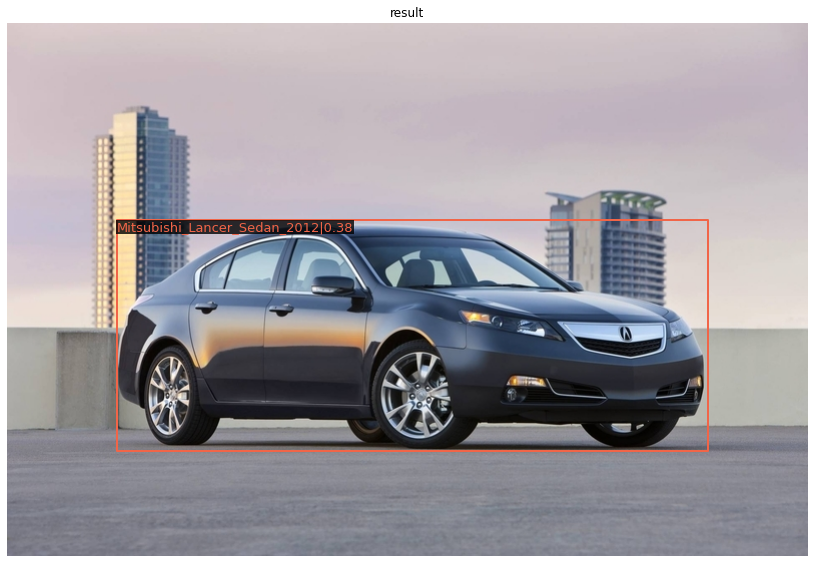

In [23]:
img = mmcv.imread('/content/data/car_ims/000165.jpg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

/content/mmdetection/mmdet/core/anchor/anchor_generator.py:323: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/content/mmdetection/mmdet/core/anchor/anchor_generator.py:360: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


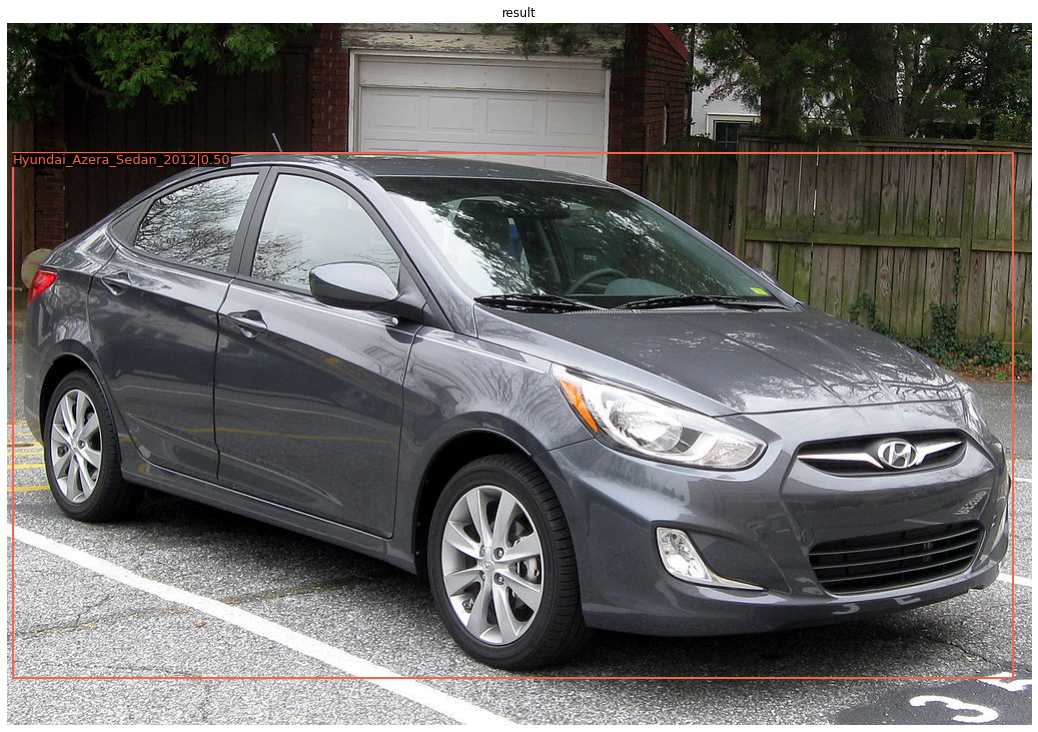

In [24]:
img = mmcv.imread('/content/data/car_ims/011205.jpg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

/content/mmdetection/mmdet/core/anchor/anchor_generator.py:323: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/content/mmdetection/mmdet/core/anchor/anchor_generator.py:360: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


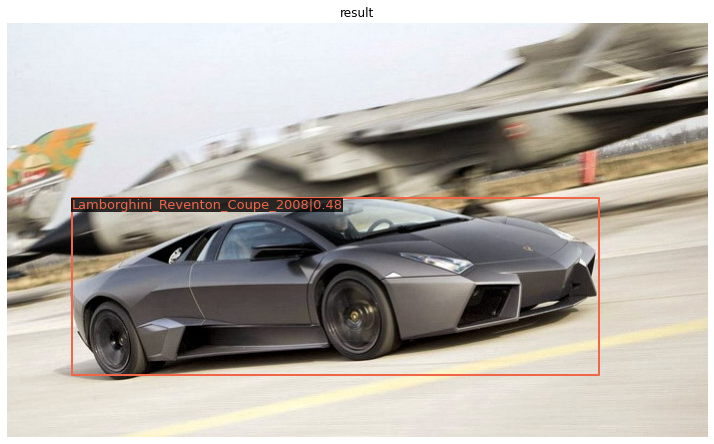

In [25]:
img = mmcv.imread('/content/data/car_ims/012321.jpg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

/content/mmdetection/mmdet/core/anchor/anchor_generator.py:323: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/content/mmdetection/mmdet/core/anchor/anchor_generator.py:360: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


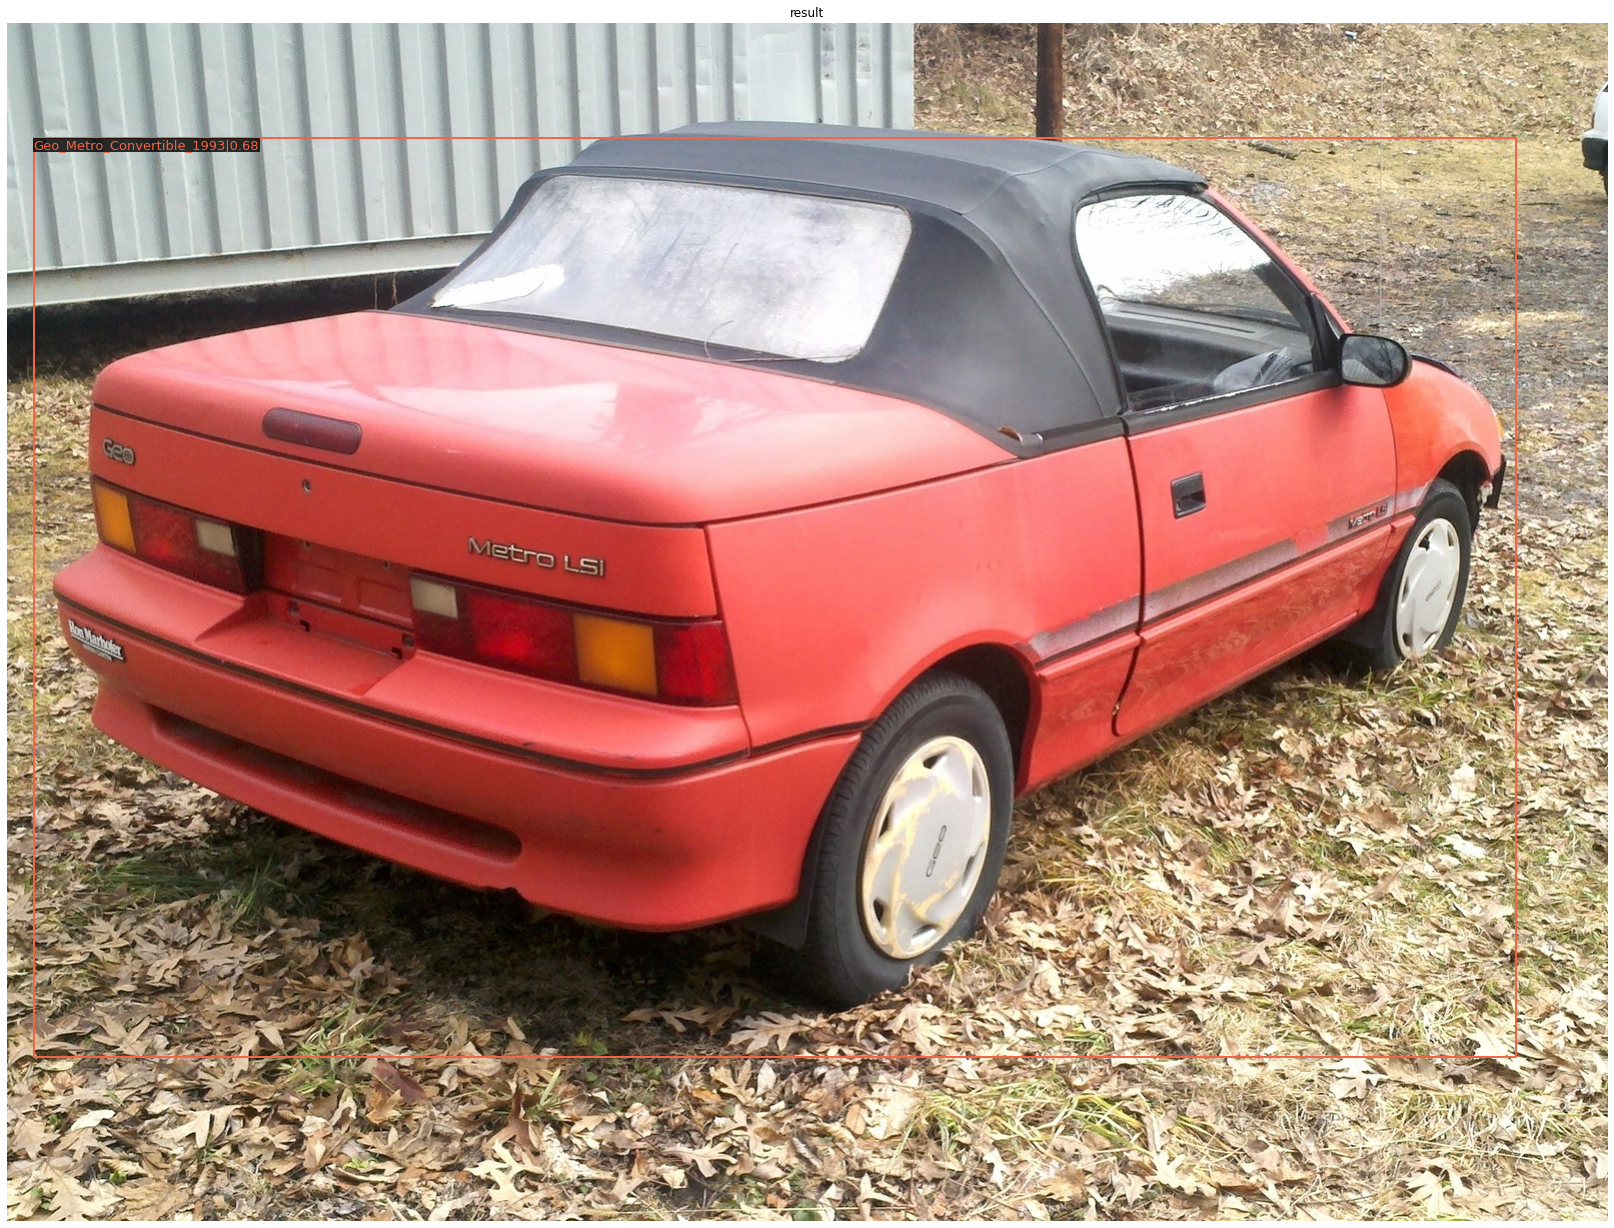

In [26]:
img = mmcv.imread('/content/data/car_ims/010135.jpg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

/content/mmdetection/mmdet/core/anchor/anchor_generator.py:323: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/content/mmdetection/mmdet/core/anchor/anchor_generator.py:360: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


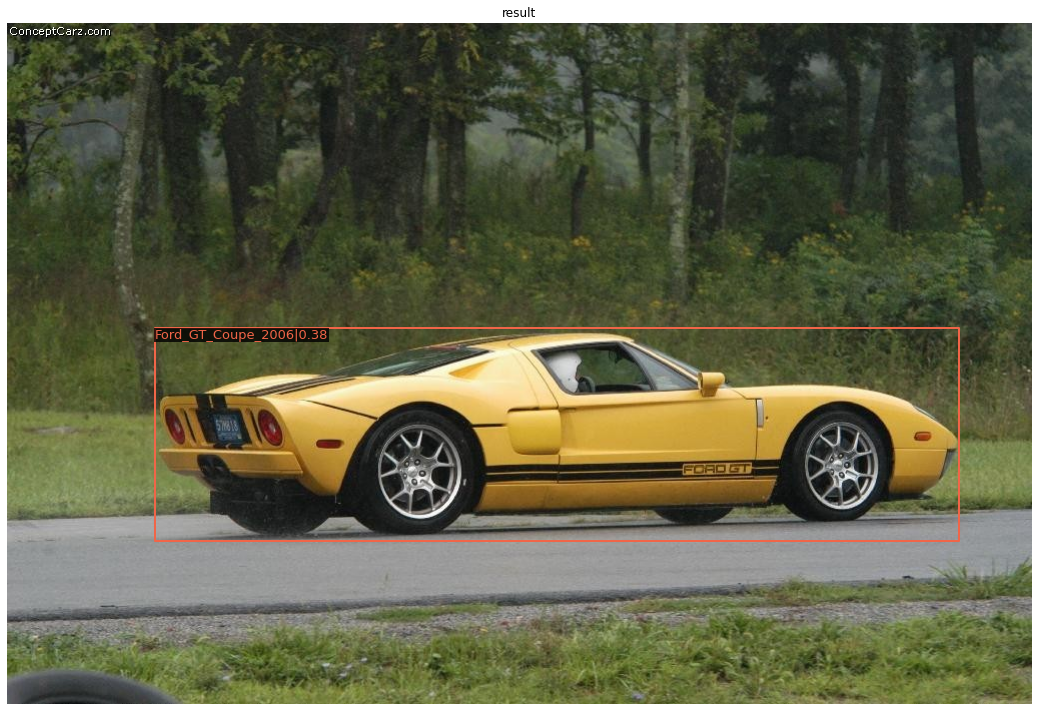

In [27]:
img = mmcv.imread('/content/data/car_ims/009135.jpg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result, score_thr=0.32)

/content/mmdetection/mmdet/core/anchor/anchor_generator.py:323: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/content/mmdetection/mmdet/core/anchor/anchor_generator.py:360: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


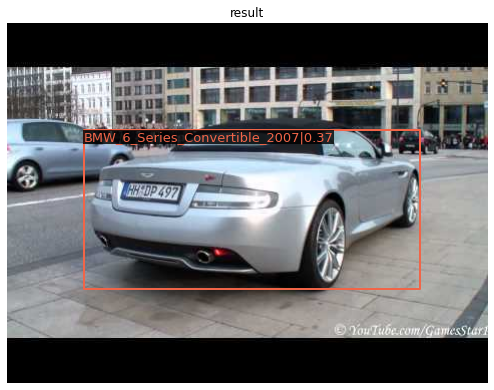

In [28]:
img = mmcv.imread('/content/data/car_ims/000776.jpg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)